In [60]:
from collections import OrderedDict
from pathlib import Path
import mne
from mne_bids import (BIDSPath, read_raw_bids, write_raw_bids)
import numpy as np
from matplotlib import pyplot as plt
import IO
import os

In [32]:

bids_root = r"C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh"
#filename = 'sub-002_ses-20200131_task-selfpacedrotation202001310001_run-4_ieeg'
filename = 'sub-000_ses-right_task-force_run-0_ieeg'

subject, session, task, run = IO.get_subject_sess_task_run(filename)
dataype = 'ieeg'
bids_path = BIDSPath(subject=subject, session=session, task=task, run=run, datatype=dataype, root=bids_root)

In [33]:
raw = read_raw_bids(bids_path)

Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_channels.tsv.
Reading in coordinate system frame other: None.
Reading electrode coords from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_space-mni_electrodes.tsv.
The read in electrodes file is: 
 [('name', ['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']), ('x', ['0.037318

<ipython-input-33-7298192decbd>:1: RuntimeWarning: Did not find any events.tsv associated with sub-000_ses-right_task-force_run-0.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\**\sub-000_ses-right*events.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-33-7298192decbd>:1: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
  raw = read_raw_bids(bids_path)
<ipython-input-33-7298192decbd>:1: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw = read_raw_bids(bids_path)


In [34]:
raw.info["dig"]

[<DigPoint |     EEG #1 : (37.3, -48.6, 61.8) mm    : MNI Talairach frame>,
 <DigPoint |     EEG #2 : (40.2, -37.3, 64.3) mm    : MNI Talairach frame>,
 <DigPoint |     EEG #3 : (40.9, -27.2, 64.1) mm    : MNI Talairach frame>,
 <DigPoint |     EEG #4 : (39.8, -17.0, 63.9) mm    : MNI Talairach frame>,
 <DigPoint |     EEG #5 : (39.7, -5.5, 61.7) mm     : MNI Talairach frame>,
 <DigPoint |     EEG #6 : (37.5, 4.3, 60.5) mm      : MNI Talairach frame>,
 <DigPoint |     EEG #7 : (nan, nan, nan) mm        : MNI Talairach frame>,
 <DigPoint |     EEG #8 : (nan, nan, nan) mm        : MNI Talairach frame>,
 <DigPoint |     EEG #9 : (nan, nan, nan) mm        : MNI Talairach frame>,
 <DigPoint |    EEG #10 : (nan, nan, nan) mm        : MNI Talairach frame>]

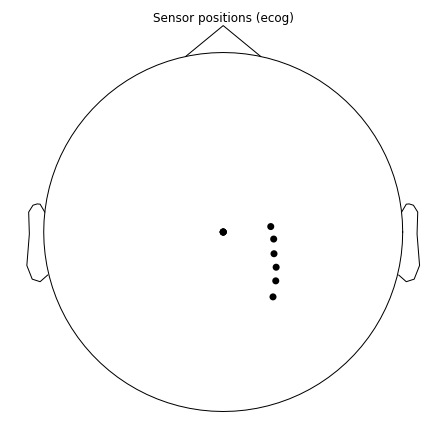

In [36]:
raw.plot_sensors()
plt.show()

In [37]:
raw.get_montage()

<DigMontage | 0 extras (headshape), 0 HPIs, 0 fiducials, 10 channels>

In [39]:
raw.plot_psd_topo?

Effective window size : 2.048 (s)


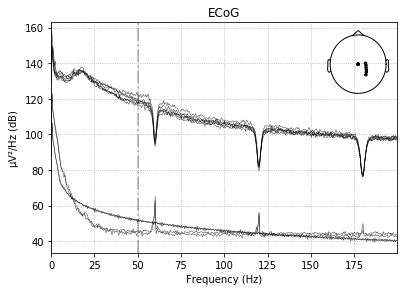

In [48]:
raw.plot_psd(fmax=200, spatial_colors=True)
plt.show()

### now try to write for every single run file the electrodes file 

In [55]:
bids_root = r"C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh"
run_files = IO.get_all_ieeg_files(bids_root)

In [64]:
filename = run_files[0]

In [92]:
for filename in run_files: 
    subject, sess, task, run = IO.get_subject_sess_task_run(os.path.basename(filename))
    dataype = 'ieeg'
    bids_path = BIDSPath(subject=subject, session=sess, task=task, run=run, datatype=dataype, root=bids_root)

    raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)

    # Read in file containing electrode locations
    electr_file = os.path.join(bids_path.directory, 'sub-'+str(subject)+'_electrodes.tsv')

    data = np.loadtxt(electr_file, dtype=str, delimiter='\t', comments=None, encoding='utf-8')
    column_names = data[0, :]
    info = data[1:, :]

    electrode_tsv = OrderedDict()
    for i, name in enumerate(column_names):
        electrode_tsv[name] = info[:, i].tolist()

    # Load in channel names
    ch_names = electrode_tsv['name']

    # Load in the xyz coordinates as a float
    elec = np.empty(shape=(len(ch_names), 3))
    for ind, axis in enumerate(['x', 'y', 'z']):
        elec[:, ind] = list(map(float, electrode_tsv[axis]))

    # Create mne montage
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, elec / 1000)), coord_frame='mni_tal')
    print('Created %s channel positions' % len(ch_names))
    print(dict(zip(ch_names, elec)))

    # Set montage. Warning is issued if channels don't match. Consider getting locations for missing channels.
    raw.set_montage(montage, on_missing='warn')

    # Write out files in BIDS format
    # Might issue SameFileError if no changes are made to raw. Can be ignored, since _ieeg files don't need to be overwritten.

    # Workaround, if raw data has been loaded.
    if raw.preload == True:
        fname_fif = bids_path.directory / (bids_path.basename + 'raw.fif')
        raw.save(fname_fif, proj=True, overwrite=True)
        raw = mne.io.read_raw_fif(fname_fif, preload=False, verbose=False)

    try:
        write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
    except:
        pass

Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_channels.tsv.
Reading electrode coords from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_space-mni_electrodes.tsv.
Created 10 channel positions
{'ECOG_RIGHT_0': array([ 37.318174  , -48.61012664,  61.79765474]), 'ECOG_RIGHT_1': array([ 40.1598943 , -37.31592983,  64.31171618]), 'ECOG_RIGHT_2': array([ 40.94303578, -27.21778456,  64.09518408]), 'ECOG_RIGHT_3': array([ 39.78395522, -

<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-000_ses-right_task-force_run-0.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\**\sub-000_ses-right*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found,

Reading electrode coords from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-1_space-mni_electrodes.tsv.
Created 10 channel positions
{'ECOG_RIGHT_0': array([ 37.318174  , -48.61012664,  61.79765474]), 'ECOG_RIGHT_1': array([ 40.1598943 , -37.31592983,  64.31171618]), 'ECOG_RIGHT_2': array([ 40.94303578, -27.21778456,  64.09518408]), 'ECOG_RIGHT_3': array([ 39.78395522, -17.00523081,  63.86618136]), 'ECOG_RIGHT_4': array([39.68813641, -5.52802457, 61.68254254]), 'ECOG_RIGHT_5': array([37.51915924,  4.30491341, 60.54126355]), 'STN_RIGHT_0': array([ 11.82808023, -15.15974827,  -7.76909846]), 'STN_RIGHT_1': array([ 12.3908352 , -14.29250828,  -5.9367987 ]), 'STN_RIGHT_2': array([ 12.93084915, -13.41284994,  -4.09165662]), 'STN_RIGHT_3': array([ 13.44457579, -12.52669693,  -2.24263538])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universität

<ipython-input-92-a44297d53bad>:6: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN']
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use

Created 10 channel positions
{'ECOG_RIGHT_0': array([ 37.318174  , -48.61012664,  61.79765474]), 'ECOG_RIGHT_1': array([ 40.1598943 , -37.31592983,  64.31171618]), 'ECOG_RIGHT_2': array([ 40.94303578, -27.21778456,  64.09518408]), 'ECOG_RIGHT_3': array([ 39.78395522, -17.00523081,  63.86618136]), 'ECOG_RIGHT_4': array([39.68813641, -5.52802457, 61.68254254]), 'ECOG_RIGHT_5': array([37.51915924,  4.30491341, 60.54126355]), 'STN_RIGHT_0': array([ 11.82808023, -15.15974827,  -7.76909846]), 'STN_RIGHT_1': array([ 12.3908352 , -14.29250828,  -5.9367987 ]), 'STN_RIGHT_2': array([ 12.93084915, -13.41284994,  -4.09165662]), 'STN_RIGHT_3': array([ 13.44457579, -12.52669693,  -2.24263538])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitä

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-000_ses-right_task-force_run-


Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	51.2	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	63.8	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	54.7	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	53.8	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "

Setting channel info structure...


<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-001_ses-left_task-force_run-0.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\**\sub-001_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any coordsystem.json associated with sub-001_ses-left_task-force_run-0.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\**\sub-001_ses-left*coordsystem.json"
  raw = read_raw_bids(b

Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-1_channels.tsv.
Created 32 channel positions
{'ECOG_LEFT_0': array([-30.5961947 , -58.9213488 ,  72.67771703]), 'ECOG_LEFT_1': array([-30.51594476, -55.38324545,  73.57326174]), 'ECOG_LEFT_2': array([-31.42569617, -50.83821812,  74.28178   ]), 'ECOG_LEFT_3': array([-33.3555723 , -46.55500542,  74.26425439]), 'ECOG_LEFT_4': array([-32.2653178 , -43.02319989,  75.16433535]), 'ECOG_LEFT_5': array([-34.17519072, -37.73936103,  74.96431955]), 'ECOG_LEFT_6': array([-37.14519478, -34.71858911,  74.40324019]), 'ECOG_LEFT_7': array([-36.025054  , -29.45364371,  74.2168331 ]), 'ECOG_LEFT_8': array([-36.95504572, -25.44484127,  73.482336  ]), 'ECOG_LEFT_9': array([-37.88503744, -21.43603883,  72.74783897]), 'ECOG_LEFT_10': array([-40.8552786 , -17.95086563,  70.56125413]), 'ECOG_LEFT_11': ar

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-001_ses-left_task-force_run-3

Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-3_channels.tsv.
Created 32 channel positions
{'ECOG_LEFT_0': array([-30.5961947 , -58.9213488 ,  72.67771703]), 'ECOG_LEFT_1': array([-30.51594476, -55.38324545,  73.57326174]), 'ECOG_LEFT_2': array([-31.42569617, -50.83821812,  74.28178   ]), 'ECOG_LEFT_3': array([-33.3555723 , -46.55500542,  74.26425439]), 'ECOG_LEFT_4': array([-32.2653178 , -43.02319989,  75.16433535]), 'ECOG_LEFT_5': array([-34.17519072, -37.73936103,  74.96431955]), 'ECOG_LEFT_6': array([-37.14519478, -34.71858911,  74.40324019]), 'ECOG_LEFT_7': array([-36.025054  , -29.45364371,  74.2168331 ]), 'ECOG_LEFT_8': array([-36.95504572, -25.44484127,  73.482336  ]), 'ECOG_LEFT_9': array([-37.88503744, -21.43603883,  72.74783897]), 'ECOG_LEFT_10': array([-40.8552786 , -17.95086563,  70.56125413]), 'ECOG_LEFT_11': ar

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-001_ses-left_task-force_run-6

Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\ses-left\ieeg\sub-001_ses-left_task-force_run-6_channels.tsv.
Created 32 channel positions
{'ECOG_LEFT_0': array([-30.5961947 , -58.9213488 ,  72.67771703]), 'ECOG_LEFT_1': array([-30.51594476, -55.38324545,  73.57326174]), 'ECOG_LEFT_2': array([-31.42569617, -50.83821812,  74.28178   ]), 'ECOG_LEFT_3': array([-33.3555723 , -46.55500542,  74.26425439]), 'ECOG_LEFT_4': array([-32.2653178 , -43.02319989,  75.16433535]), 'ECOG_LEFT_5': array([-34.17519072, -37.73936103,  74.96431955]), 'ECOG_LEFT_6': array([-37.14519478, -34.71858911,  74.40324019]), 'ECOG_LEFT_7': array([-36.025054  , -29.45364371,  74.2168331 ]), 'ECOG_LEFT_8': array([-36.95504572, -25.44484127,  73.482336  ]), 'ECOG_LEFT_9': array([-37.88503744, -21.43603883,  72.74783897]), 'ECOG_LEFT_10': array([-40.8552786 , -17.95086563,  70.56125413]), 'ECOG_LEFT_11': ar

Setting channel info structure...


<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-001_ses-left_task-force_run-7


Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	63.8	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	54.7	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	53.8	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "D

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-001_ses-right_task-force_run-2.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\**\sub-001_ses-right*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any coordsystem.json associated with sub-001_ses-right_task-force_run-2.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\**\sub-001_ses-right*coordsystem.json"
  raw = read_raw_bi


Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	63.8	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	54.7	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	53.8	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "D

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-001_ses-right_task-force_run-4.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\**\sub-001_ses-right*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels a

Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\ses-right\ieeg\sub-001_ses-right_task-force_run-5_channels.tsv.
Created 32 channel positions
{'ECOG_RIGHT_0': array([ 29.12607696, -47.416972  ,  70.67875147]), 'ECOG_RIGHT_1': array([ 28.2062054 , -43.14005712,  70.65861791]), 'ECOG_RIGHT_2': array([ 29.31646311, -38.60762543,  71.77088355]), 'ECOG_RIGHT_3': array([ 31.44660846, -33.34897785,  71.48898365]), 'ECOG_RIGHT_4': array([ 30.50673368, -30.07268912,  71.75170991]), 'ECOG_RIGHT_5': array([ 31.62687446, -24.80774372,  71.46277886]), 'ECOG_RIGHT_6': array([ 34.72701794, -21.55664626,  71.75362975]), 'ECOG_RIGHT_7': array([ 34.83715415, -16.28540304,  71.45766754]), 'ECOG_RIGHT_8': array([ 35.92717157, -12.28919624,  70.33325942]), 'ECOG_RIGHT_9': array([37.01718898, -8.29298943, 69.2088513 ]), 'ECOG_RIGHT_10': array([40.11709538, -4.57

<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-001_ses-right_task-force_run-5.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-001\**\sub-001_ses-right*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your ana


Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	54.7	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	53.8	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "De


Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...


<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-002_ses-right_task-force_run-1.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-002\**\sub-002_ses-right*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels a


participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	53.8	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
            "M": "male"
        }
    },
    "hand": {
        "D

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-003_ses-left_task-force_run-3.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-003\**\sub-003_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are

Created 12 channel positions
{'ECOG_RIGHT_0': array([ 26.39549055, -55.64905549,  66.92111699]), 'ECOG_RIGHT_1': array([ 28.17563501, -45.22872609,  68.9363955 ]), 'ECOG_RIGHT_2': array([ 30.21724849, -35.76733062,  69.02694019]), 'ECOG_RIGHT_3': array([ 37.68295528, -26.22272584,  67.51219561]), 'ECOG_RIGHT_4': array([ 43.30636037, -16.26163763,  64.19133509]), 'ECOG_RIGHT_5': array([43.89787571, -7.82215963, 59.5886631 ]), 'ECOG_RIGHT_6': array([43.20854195,  1.55536761, 56.74455442]), 'ECOG_RIGHT_7': array([42.51992152, 13.28780137, 53.83999665]), 'STN_RIGHT_0': array([41.59987455,  5.28506887, -0.71833384]), 'STN_RIGHT_1': array([41.11458357,  4.63706755,  1.43063848]), 'STN_RIGHT_2': array([40.63463929,  3.97147465,  3.55647378]), 'STN_RIGHT_3': array([40.16600587,  3.29359956,  5.66725148])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-003\ses-right\ieeg\sub-003_ses-

Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-003\ses-right\ieeg\sub-003_ses-right_task-force_run-4_channels.tsv.
Created 12 channel positions
{'ECOG_RIGHT_0': array([ 26.39549055, -55.64905549,  66.92111699]), 'ECOG_RIGHT_1': array([ 28.17563501, -45.22872609,  68.9363955 ]), 'ECOG_RIGHT_2': array([ 30.21724849, -35.76733062,  69.02694019]), 'ECOG_RIGHT_3': array([ 37.68295528, -26.22272584,  67.51219561]), 'ECOG_RIGHT_4': array([ 43.30636037, -16.26163763,  64.19133509]), 'ECOG_RIGHT_5': array([43.89787571, -7.82215963, 59.5886631 ]), 'ECOG_RIGHT_6': array([43.20854195,  1.55536761, 56.74455442]), 'ECOG_RIGHT_7': array([42.51992152, 13.28780137, 53.83999665]), 'STN_RIGHT_0': array([41.59987455,  5.28506887, -0.71833384]), 'STN_RIGHT_1': array([41.11458357,  4.63706755,  1.43063848]), 'STN_RIGHT_2': array([40.63463929,  3.97147465,  3.55647

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-003_ses-right_task-force_run-


Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-003\ses-right\ieeg\sub-003_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	53.8	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BID

{'ECOG_LEFT_0': array([-21.33445138, -58.92032609,  71.52366489]), 'ECOG_LEFT_1': array([-22.92401978, -50.69262099,  75.16485184]), 'ECOG_LEFT_2': array([-27.42893488, -38.94533587,  76.84774585]), 'ECOG_LEFT_3': array([-26.93765389, -30.87249681,  78.0871751 ]), 'ECOG_LEFT_4': array([-30.42831682, -19.66556916,  76.43455283]), 'ECOG_LEFT_5': array([-27.80456832, -10.90935033,  74.77559841]), 'ECOG_LEFT_6': array([-30.28097909,  -0.24278013,  69.78745987]), 'ECOG_LEFT_7': array([-31.71641998,  10.41205934,  67.17286809]), 'STN_LEFT_0': array([-13.07562124, -15.24096917,  -9.84262103]), 'STN_LEFT_1': array([-13.59789339, -14.41025393,  -7.9635373 ]), 'STN_LEFT_2': array([-14.14143163, -13.58861663,  -6.10743099]), 'STN_LEFT_3': array([-14.70722563, -12.76454403,  -4.26350892])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-004\ses-left\ieeg\sub-004_ses-left_task-force_run-0

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-003_ses-right_task-force_run-


participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
            "M": "male"
        }
    },
    "hand": {
        "De

Setting channel info structure...


<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-004_ses-right_task-force_run-1.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-004\**\sub-004_ses-right*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any coordsystem.json associated with sub-004_ses-right_task-force_run-1.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-004\**\sub-004_ses-right*coordsystem.json"
  raw = read_raw_bi


Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Desc

{'ECOG_LEFT_0': array([-58.41869039, -13.9623285 ,  52.44562906]), 'ECOG_LEFT_1': array([-57.51509913, -21.5698493 ,  56.40972343]), 'ECOG_LEFT_2': array([-52.72045409, -29.14040668,  61.99288522]), 'ECOG_LEFT_3': array([-49.7468157 , -38.537043  ,  64.57271393]), 'ECOG_LEFT_4': array([-45.42808314, -46.39301698,  65.63242176]), 'ECOG_LEFT_5': array([-43.90336666, -54.69346812,  64.21533174]), 'ECOG_LEFT_6': array([-45.92222808, -61.41611027,  59.50678603]), 'ECOG_LEFT_7': array([-45.82182468, -67.3128845 ,  54.77157989]), 'STN_LEFT_0': array([-13.11867968, -14.48774351,  -6.4121257 ]), 'STN_LEFT_1': array([-13.78558739, -13.83495011,  -4.56013124]), 'STN_LEFT_2': array([-14.46594142, -13.17969662,  -2.73708256]), 'STN_LEFT_3': array([-15.15275258, -12.51061222,  -0.92896123])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-005\ses-left\ieeg\sub-005_ses-left_task-force_run-1

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-005_ses-left_task-force_run-0.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-005\**\sub-005_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any coordsystem.json associated with sub-005_ses-left_task-force_run-0.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-005\**\sub-005_ses-left*coordsystem.json"
  raw = read_raw_bids(b


Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Desc

Setting channel info structure...


<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-005_ses-left_task-force_run-3.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-005\**\sub-005_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are


Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Desc

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-005_ses-right_task-force_run-2.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-005\**\sub-005_ses-right*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any coordsystem.json associated with sub-005_ses-right_task-force_run-2.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-005\**\sub-005_ses-right*coordsystem.json"
  raw = read_raw_bi

Created 40 channel positions
{'ECOG_LEFT_0': array([-41.56441335,  38.70967937, -14.79683704]), 'ECOG_LEFT_1': array([-48.76519539,  37.37805512,  -7.21088227]), 'ECOG_LEFT_2': array([-53.21326756,  34.53562139,   3.01254064]), 'ECOG_LEFT_3': array([-55.0096794 ,  31.12149196,  11.03440349]), 'ECOG_LEFT_4': array([-55.02295069,  26.67574075,  19.31514693]), 'ECOG_LEFT_5': array([-54.11717742,  22.22035873,  27.55496381]), 'ECOG_LEFT_6': array([-50.2938487 ,  19.29124775,  37.41004771]), 'ECOG_LEFT_7': array([-40.6881457 ,  19.1432772 ,  49.45627544]), 'ECOG_LEFT_8': array([-59.09577759, -50.46178766,  48.66981306]), 'ECOG_LEFT_9': array([-56.98958149, -47.64212401,  51.02466313]), 'ECOG_LEFT_10': array([-58.50240315, -43.03061843,  51.8223618 ]), 'ECOG_LEFT_11': array([-57.42293678, -41.48508579,  53.51948193]), 'ECOG_LEFT_12': array([-59.90532776, -36.39439251,  51.93859306]), 'ECOG_LEFT_13': array([-59.74269405, -34.09827053,  52.29651585]), 'ECOG_LEFT_14': array([-58.44343355, -28.5

<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any coordsystem.json associated with sub-006_ses-left_task-force_run-0.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-006\**\sub-006_ses-left*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown i

Created 40 channel positions
{'ECOG_LEFT_0': array([-41.56441335,  38.70967937, -14.79683704]), 'ECOG_LEFT_1': array([-48.76519539,  37.37805512,  -7.21088227]), 'ECOG_LEFT_2': array([-53.21326756,  34.53562139,   3.01254064]), 'ECOG_LEFT_3': array([-55.0096794 ,  31.12149196,  11.03440349]), 'ECOG_LEFT_4': array([-55.02295069,  26.67574075,  19.31514693]), 'ECOG_LEFT_5': array([-54.11717742,  22.22035873,  27.55496381]), 'ECOG_LEFT_6': array([-50.2938487 ,  19.29124775,  37.41004771]), 'ECOG_LEFT_7': array([-40.6881457 ,  19.1432772 ,  49.45627544]), 'ECOG_LEFT_8': array([-59.09577759, -50.46178766,  48.66981306]), 'ECOG_LEFT_9': array([-56.98958149, -47.64212401,  51.02466313]), 'ECOG_LEFT_10': array([-58.50240315, -43.03061843,  51.8223618 ]), 'ECOG_LEFT_11': array([-57.42293678, -41.48508579,  53.51948193]), 'ECOG_LEFT_12': array([-59.90532776, -36.39439251,  51.93859306]), 'ECOG_LEFT_13': array([-59.74269405, -34.09827053,  52.29651585]), 'ECOG_LEFT_14': array([-58.44343355, -28.5

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-006_ses-left_task-force_run-5

Created 40 channel positions
{'ECOG_LEFT_0': array([-41.56441335,  38.70967937, -14.79683704]), 'ECOG_LEFT_1': array([-48.76519539,  37.37805512,  -7.21088227]), 'ECOG_LEFT_2': array([-53.21326756,  34.53562139,   3.01254064]), 'ECOG_LEFT_3': array([-55.0096794 ,  31.12149196,  11.03440349]), 'ECOG_LEFT_4': array([-55.02295069,  26.67574075,  19.31514693]), 'ECOG_LEFT_5': array([-54.11717742,  22.22035873,  27.55496381]), 'ECOG_LEFT_6': array([-50.2938487 ,  19.29124775,  37.41004771]), 'ECOG_LEFT_7': array([-40.6881457 ,  19.1432772 ,  49.45627544]), 'ECOG_LEFT_8': array([-59.09577759, -50.46178766,  48.66981306]), 'ECOG_LEFT_9': array([-56.98958149, -47.64212401,  51.02466313]), 'ECOG_LEFT_10': array([-58.50240315, -43.03061843,  51.8223618 ]), 'ECOG_LEFT_11': array([-57.42293678, -41.48508579,  53.51948193]), 'ECOG_LEFT_12': array([-59.90532776, -36.39439251,  51.93859306]), 'ECOG_LEFT_13': array([-59.74269405, -34.09827053,  52.29651585]), 'ECOG_LEFT_14': array([-58.44343355, -28.5

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-006_ses-right_task-force_run-

Created 40 channel positions
{'ECOG_RIGHT_0': array([ 22.72220104,  52.02004098, -18.93213709]), 'ECOG_RIGHT_1': array([33.35905753, 54.62811851, -8.98842724]), 'ECOG_RIGHT_2': array([38.36732593, 53.78734345,  4.64255719]), 'ECOG_RIGHT_3': array([42.02802094, 48.56211048, 14.13971831]), 'ECOG_RIGHT_4': array([42.93158232, 43.36576993, 23.7596591 ]), 'ECOG_RIGHT_5': array([44.64650306, 36.87603676, 32.64001684]), 'ECOG_RIGHT_6': array([43.60650206, 31.15615454, 40.26303035]), 'ECOG_RIGHT_7': array([42.40165546, 22.39919181, 48.90824498]), 'ECOG_RIGHT_8': array([ 29.1516544 , -50.19627734,  70.39143324]), 'ECOG_RIGHT_9': array([ 31.26006238, -46.63565516,  71.3661594 ]), 'ECOG_RIGHT_10': array([ 31.64027833, -41.03105101,  71.74127126]), 'ECOG_RIGHT_11': array([ 30.93881603, -37.71293805,  71.79938689]), 'ECOG_RIGHT_12': array([ 34.83257645, -34.44297912,  71.65286973]), 'ECOG_RIGHT_13': array([ 36.94319631, -30.1413984 ,  71.24747198]), 'ECOG_RIGHT_14': array([ 38.18972015, -24.8178267

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-006_ses-right_task-force_run-

Created 40 channel positions
{'ECOG_RIGHT_0': array([ 22.72220104,  52.02004098, -18.93213709]), 'ECOG_RIGHT_1': array([33.35905753, 54.62811851, -8.98842724]), 'ECOG_RIGHT_2': array([38.36732593, 53.78734345,  4.64255719]), 'ECOG_RIGHT_3': array([42.02802094, 48.56211048, 14.13971831]), 'ECOG_RIGHT_4': array([42.93158232, 43.36576993, 23.7596591 ]), 'ECOG_RIGHT_5': array([44.64650306, 36.87603676, 32.64001684]), 'ECOG_RIGHT_6': array([43.60650206, 31.15615454, 40.26303035]), 'ECOG_RIGHT_7': array([42.40165546, 22.39919181, 48.90824498]), 'ECOG_RIGHT_8': array([ 29.1516544 , -50.19627734,  70.39143324]), 'ECOG_RIGHT_9': array([ 31.26006238, -46.63565516,  71.3661594 ]), 'ECOG_RIGHT_10': array([ 31.64027833, -41.03105101,  71.74127126]), 'ECOG_RIGHT_11': array([ 30.93881603, -37.71293805,  71.79938689]), 'ECOG_RIGHT_12': array([ 34.83257645, -34.44297912,  71.65286973]), 'ECOG_RIGHT_13': array([ 36.94319631, -30.1413984 ,  71.24747198]), 'ECOG_RIGHT_14': array([ 38.18972015, -24.8178267

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-006_ses-right_task-force_run-


Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-4_ieeg.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-006_ses-right_task-force_run-6.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-006\**\sub-006_ses-righ


Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-006\ses-right\ieeg\sub-006_ses-right_task-force_run-6_ieeg.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS

Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...


<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-007_ses-left_task-force_run-0


participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
            "M": "male"
        }
    },
    "hand": {
        "De

Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a


<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-008_ses-left_task-force_run-1.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-008\**\sub-008_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are


Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
            "M": "male"
        }
    },
    "hand": {
        "Description": "Handedness of the participant",
        "Levels": {
            "R": "right",
            "L": "left",
            "A": "ambidextrous"
        }
    }
}
Writing electrodes file to...  C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-009\ses-left\ieeg\sub-009_ses-left_task-force_run-0_electrodes.tsv
Writing coordsytem file to...  C:\Users\ICN_admin\Char

Writing electrodes file to...  C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-009\ses-left\ieeg\sub-009_ses-left_task-force_run-2_electrodes.tsv
Writing coordsytem file to...  C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-009\ses-left\ieeg\sub-009_ses-left_coordsystem.json

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-009\ses-left\ieeg\sub-009_ses-left_task-force_run-2_space-mni_electrodes.tsv'...

name	x	y	z	size	impedance
ECOG_LEFT_0	-0.025068922474896393	-0.026337741446547436	0.07460864507754762	n/a	n/a
ECOG_LEFT_1	-0.03501778654585318	-0.016691160377280773	0.0706313508622395	n/a	n/a
ECOG_LEFT_2	-0.04116403380903576	-0.01002068775469156	0.06538932438560852	n/a	n/a
ECOG_LEFT_3	-0.047274307974804475	-0.00243435997828089

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-009_ses-left_task-force_run-1.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-009\**\sub-009_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are

Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-009\ses-left\ieeg\sub-009_ses-left_task-force_run-3_channels.tsv.
Created 10 channel positions
{'ECOG_LEFT_0': array([-25.06892247, -26.33774145,  74.60864508]), 'ECOG_LEFT_1': array([-35.01778655, -16.69116038,  70.63135086]), 'ECOG_LEFT_2': array([-41.16403381, -10.02068775,  65.38932439]), 'ECOG_LEFT_3': array([-47.27430797,  -2.43435998,  59.64077368]), 'ECOG_LEFT_4': array([-48.26625772,   3.99209788,  53.85477316]), 'ECOG_LEFT_5': array([-46.78720283,  12.66058447,  50.10856102]), 'STN_LEFT_0': array([-12.98156488, -14.7847171 ,  -7.46680041]), 'STN_LEFT_1': array([-13.57567267, -13.82814988,  -5.7923246 ]), 'STN_LEFT_2': array([-14.16675131, -12.88159445,  -4.13556196]), 'STN_LEFT_3': array([-14.75114941, -11.94122085,  -2.49187268])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interv

Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-010\ses-left\ieeg\sub-010_ses-left_task-force_run-0_channels.tsv.
Created 10 channel positions
{'ECOG_LEFT_0': array([-53.40543113, -22.0825916 ,  58.48703105]), 'ECOG_LEFT_1': array([-53.73699777, -12.09026969,  55.45707681]), 'ECOG_LEFT_2': array([-52.19412884,  -3.00074977,  53.27996658]), 'ECOG_LEFT_3': array([-51.46479192,   5.06828777,  49.14559767]), 'ECOG_LEFT_4': array([-49.75302693,  13.10495837,  45.15766293]), 'ECOG_LEFT_5': array([-45.17842577,  21.57095278,  42.51444292]), 'STN_LEFT_0': array([-11.66579382, -12.61817999,  -7.657352  ]), 'STN_LEFT_1': array([-12.27619699, -11.27017431,  -6.01108327]), 'STN_LEFT_2': array([-12.88660016,  -9.92216863,  -4.36481455]), 'STN_LEFT_3': array([-13.49700334,  -8.57416294,  -2.71854582])}
Extracting parameters from C:\Users\ICN_admin\Charité -

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-009_ses-left_task-force_run-4

Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-010_ses-left_task-force_run-1.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-010\**\sub-010_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are

Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"

Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...


<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-010_ses-left_task-force_run-5.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-010\**\sub-010_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are


participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
            "M": "male"
        }
    },
    "hand": {
        "De

{'ECOG_LEFT_0': array([-53.40543113, -22.0825916 ,  58.48703105]), 'ECOG_LEFT_1': array([-53.73699777, -12.09026969,  55.45707681]), 'ECOG_LEFT_2': array([-52.19412884,  -3.00074977,  53.27996658]), 'ECOG_LEFT_3': array([-51.46479192,   5.06828777,  49.14559767]), 'ECOG_LEFT_4': array([-49.75302693,  13.10495837,  45.15766293]), 'ECOG_LEFT_5': array([-45.17842577,  21.57095278,  42.51444292]), 'STN_LEFT_0': array([-11.66579382, -12.61817999,  -7.657352  ]), 'STN_LEFT_1': array([-12.27619699, -11.27017431,  -6.01108327]), 'STN_LEFT_2': array([-12.88660016,  -9.92216863,  -4.36481455]), 'STN_LEFT_3': array([-13.49700334,  -8.57416294,  -2.71854582])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-010\ses-left\ieeg\sub-010_ses-left_task-force_run-8_ieeg.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cog

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-010_ses-left_task-force_run-7.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-010\**\sub-010_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are


participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
            "M": "male"
        }
    },
    "hand": {
        "De

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-010_ses-right_task-force_run-2.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-010\**\sub-010_ses-right*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any coordsystem.json associated with sub-010_ses-right_task-force_run-2.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-010\**\sub-010_ses-right*coordsystem.json"
  raw = read_raw_bi

Created 10 channel positions
{'ECOG_RIGHT_0': array([ 47.05582853, -20.44116372,  63.71003876]), 'ECOG_RIGHT_1': array([ 46.54939331, -10.76048525,  62.14547247]), 'ECOG_RIGHT_2': array([46.21782666, -0.76816334, 59.11551824]), 'ECOG_RIGHT_3': array([45.79583946,  8.38609047, 56.64553969]), 'ECOG_RIGHT_4': array([45.54872085, 17.85198772, 52.7101732 ]), 'ECOG_RIGHT_5': array([39.31661329, 26.67401856, 48.45617743]), 'STN_RIGHT_0': array([  8.17499687, -15.06999531, -11.56127554]), 'STN_RIGHT_1': array([  8.77750555, -13.77182014,  -9.99154277]), 'STN_RIGHT_2': array([  9.38001423, -12.47364496,  -8.42181001]), 'STN_RIGHT_3': array([  9.98252292, -11.17546978,  -6.85207724])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-010\ses-right\ieeg\sub-010_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedi

Created 6 channel positions
{'ECOG_LEFT_0': array([ -1.10833333, -70.23333333,  61.15      ]), 'ECOG_LEFT_1': array([-21.18032787, -64.95081967,  69.52459016]), 'ECOG_LEFT_2': array([-29.87096774, -54.74193548,  73.71774194]), 'ECOG_LEFT_3': array([-28.07407407, -44.43518519,  75.75925926]), 'ECOG_LEFT_4': array([-30.2987013 , -35.53246753,  75.7987013 ]), 'ECOG_LEFT_5': array([-37.93333333, -25.59333333,  74.33333333])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-011\ses-left\ieeg\sub-011_ses-left_task-force_run-1_ieeg.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...


<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-011_ses-left_task-force_run-0


participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
            "M": "male"
        }
    },
    "hand": {
        "De

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-011_ses-left_task-force_run-2.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-011\**\sub-011_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are


Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-012\ses-left\ieeg\sub-012_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS P

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-012_ses-left_task-force_run-3

Created 10 channel positions
{'ECOG_LEFT_0': array([-29.29326923, -40.75      ,  77.29326923]), 'ECOG_LEFT_1': array([-29.703125, -30.203125,  78.046875]), 'ECOG_LEFT_2': array([-30.70930233, -18.45348837,  76.63372093]), 'ECOG_LEFT_3': array([-32.13924051,  -7.72151899,  72.34177215]), 'ECOG_LEFT_4': array([-34.54375,   1.41875,  67.60625]), 'ECOG_LEFT_5': array([-33.90384615,  12.18589744,  66.42307692]), 'STN_LEFT_0': array([-26.61792333, -11.14227759,  -2.79392768]), 'STN_LEFT_1': array([-26.74146468,  -9.72371065,  -1.23395072]), 'STN_LEFT_2': array([-26.88877329,  -8.31362142,   0.33190961]), 'STN_LEFT_3': array([-27.07685474,  -6.88970401,   1.90612077])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-012\ses-left\ieeg\sub-012_ses-left_task-force_run-5_ieeg.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Inte

Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-012\ses-left\ieeg\sub-012_ses-left_task-force_run-8_channels.tsv.


<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-012_ses-left_task-force_run-7

Created 10 channel positions
{'ECOG_LEFT_0': array([-29.29326923, -40.75      ,  77.29326923]), 'ECOG_LEFT_1': array([-29.703125, -30.203125,  78.046875]), 'ECOG_LEFT_2': array([-30.70930233, -18.45348837,  76.63372093]), 'ECOG_LEFT_3': array([-32.13924051,  -7.72151899,  72.34177215]), 'ECOG_LEFT_4': array([-34.54375,   1.41875,  67.60625]), 'ECOG_LEFT_5': array([-33.90384615,  12.18589744,  66.42307692]), 'STN_LEFT_0': array([-26.61792333, -11.14227759,  -2.79392768]), 'STN_LEFT_1': array([-26.74146468,  -9.72371065,  -1.23395072]), 'STN_LEFT_2': array([-26.88877329,  -8.31362142,   0.33190961]), 'STN_LEFT_3': array([-27.07685474,  -6.88970401,   1.90612077])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-012\ses-left\ieeg\sub-012_ses-left_task-force_run-8_ieeg.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Inte

Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-012\ses-right\ieeg\sub-012_ses-right_task-force_run-2_channels.tsv.


<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-012_ses-right_task-force_run-

Created 14 channel positions
{'ECOG_RIGHT_0': array([16.72340426, 68.95744681, 22.72340426]), 'ECOG_RIGHT_1': array([15.91044776, 61.61940299, 32.59701493]), 'ECOG_RIGHT_2': array([14.84, 54.95, 43.39]), 'ECOG_RIGHT_3': array([12.51282051, 46.78205128, 53.47435897]), 'ECOG_RIGHT_4': array([ 46.68181818, -51.71428571,  63.55844156]), 'ECOG_RIGHT_5': array([ 43.85416667, -38.04861111,  68.94444444]), 'ECOG_RIGHT_6': array([ 42.14102564, -25.42307692,  71.42307692]), 'ECOG_RIGHT_7': array([ 37.59375, -14.90625,  71.96875]), 'ECOG_RIGHT_8': array([33.57575758, -6.62121212, 70.68181818]), 'ECOG_RIGHT_9': array([33.64583333,  0.3125    , 68.44791667]), 'STN_LEFT_0': array([21.33370902, -6.42186705, -2.63748741]), 'STN_LEFT_1': array([21.08042235, -5.45923244, -0.72348329]), 'STN_LEFT_2': array([20.85887348, -4.4822331 ,  1.19000013]), 'STN_LEFT_3': array([20.67020023, -3.50199563,  3.12028488])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional


{
    "iEEGCoordinateSystem": "Other",
    "iEEGCoordinateSystemDescription": "n/a",
    "iEEGCoordinateUnits": "m"
}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-012\ses-right\ieeg\sub-012_ses-right_task-force_run-6_ieeg.vhdr...
Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-012\ses-right\ieeg\sub-012_ses-right_task-force_run-6_channels.tsv.


<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-012_ses-right_task-force_run-

Created 14 channel positions
{'ECOG_RIGHT_0': array([16.72340426, 68.95744681, 22.72340426]), 'ECOG_RIGHT_1': array([15.91044776, 61.61940299, 32.59701493]), 'ECOG_RIGHT_2': array([14.84, 54.95, 43.39]), 'ECOG_RIGHT_3': array([12.51282051, 46.78205128, 53.47435897]), 'ECOG_RIGHT_4': array([ 46.68181818, -51.71428571,  63.55844156]), 'ECOG_RIGHT_5': array([ 43.85416667, -38.04861111,  68.94444444]), 'ECOG_RIGHT_6': array([ 42.14102564, -25.42307692,  71.42307692]), 'ECOG_RIGHT_7': array([ 37.59375, -14.90625,  71.96875]), 'ECOG_RIGHT_8': array([33.57575758, -6.62121212, 70.68181818]), 'ECOG_RIGHT_9': array([33.64583333,  0.3125    , 68.44791667]), 'STN_LEFT_0': array([21.33370902, -6.42186705, -2.63748741]), 'STN_LEFT_1': array([21.08042235, -5.45923244, -0.72348329]), 'STN_LEFT_2': array([20.85887348, -4.4822331 ,  1.19000013]), 'STN_LEFT_3': array([20.67020023, -3.50199563,  3.12028488])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional

Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-013\ses-left\ieeg\sub-013_ses-left_task-force_run-1_channels.tsv.
Created 10 channel positions
{'ECOG_LEFT_0': array([-24.31175252, -48.66622827,  71.62371708]), 'ECOG_LEFT_1': array([-26.48466624, -38.62755841,  70.32617498]), 'ECOG_LEFT_2': array([-28.33275588, -28.4335258 ,  69.81622333]), 'ECOG_LEFT_3': array([-30.40031442, -19.46383251,  68.06707619]), 'ECOG_LEFT_4': array([-33.50193152, -11.60505839,  64.01937905]), 'ECOG_LEFT_5': array([-36.97793658,  -2.73717556,  59.49827914]), 'STN_LEFT_0': array([-14.266, -18.68 , -11.49 ]), 'STN_LEFT_1': array([-14.8883, -17.947 ,  -9.3502]), 'STN_LEFT_2': array([-15.504 , -17.2129,  -7.2233]), 'STN_LEFT_3': array([-16.1175, -16.4815,  -5.1086])}
Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitiv

<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-013_ses-left_task-force_run-0


Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Desc

Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-014_ses-right_task-force_run-0.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-014\**\sub-014_ses-right*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any coordsystem.json associated with sub-014_ses-right_task-force_run-0.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-014\**\sub-014_ses-right*coordsystem.json"
  raw = read_raw_bi

Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-014\ses-right\ieeg\sub-014_ses-right_task-force_run-2_channels.tsv.
Created 10 channel positions
{'ECOG_RIGHT_0': array([ 15.75948443, -36.33389497,  70.67824381]), 'ECOG_RIGHT_1': array([ 19.98270199, -26.37155434,  68.9606791 ]), 'ECOG_RIGHT_2': array([ 22.39200905, -16.87765229,  65.71559277]), 'ECOG_RIGHT_3': array([27.31827282, -7.7580953 , 60.91576832]), 'ECOG_RIGHT_4': array([40.32268352, -1.23647774, 54.36056867]), 'ECOG_RIGHT_5': array([43.42095913,  6.34938298, 48.33519683]), 'STN_RIGHT_0': array([ 14.8129548 , -14.13439076,  -3.86749406]), 'STN_RIGHT_1': array([ 15.16417687, -13.05369838,  -1.96618262]), 'STN_RIGHT_2': array([ 15.50933446, -11.93704921,  -0.07721977]), 'STN_RIGHT_3': array([ 15.84991962, -10.78830246,   1.81018214])}
Extracting parameters from C:\Users\ICN_admin\Charit

<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-014_ses-right_task-force_run-2.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-014\**\sub-014_ses-right*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_LEFT', 'MOV_RIGHT_CLEAN', 'MOV_LEFT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your ana


Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
            "M": "male"
        }
    },
    "hand": {
        "Description": "Handedness of the participant",
        "Levels": {
            "R": "right",
            "L": "left",
            "A": "ambidextrous"
        }
    }
}
Writing electrodes file to...  C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-015\ses-left\ieeg\sub-015_ses-left_task-force_run-0_electrodes.tsv
Writing coordsytem file to...  C:\Users\ICN_admin\Char

Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...


<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-015_ses-left_task-force_run-1.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-015\**\sub-015_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are


participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
            "M": "male"
        }
    },
    "hand": {
        "De

Setting channel info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.tsv'...

participant_id	age	sex	center_ID	disease	center	curator	UPDRS_total	UPDRS_left	UPDRS_right	line_noise	Length_of_diagnosis_prior_to_surgery	hand
sub-000	n/a	F	DBS4017	PD	UPMC	Richardson	28	11	9	60	10.7	n/a
sub-001	n/a	M	DBS4029	PD	UPMC	Richardson	27	5	7	60	14	n/a
sub-002	n/a	M	DBS4011	PD	UPMC	Richardson	40	10	16	60	4.5	n/a
sub-003	n/a	M	DBS4020	PD	UPMC	Richardson	n/a	n/a	n/a	60	21.8	n/a
sub-004	n/a	M	DBS4033	PD	UPMC	Richardson	33	13	13	60	7.2	n/a

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"

<ipython-input-92-a44297d53bad>:45: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-015_ses-left_task-force_run-3.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-015\**\sub-015_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The required channels are

Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-016\ses-left\ieeg\sub-016_ses-left_task-force_run-1_channels.tsv.
Created 14 channel positions
{'ECOG_LEFT_0': array([-40., -73.,  40.]), 'ECOG_LEFT_1': array([-41. , -64. ,  46.5]), 'ECOG_LEFT_2': array([-41. , -55. ,  52.5]), 'ECOG_LEFT_3': array([-40. , -44.5,  55.5]), 'ECOG_LEFT_4': array([-40. , -34.5,  59.5]), 'ECOG_LEFT_5': array([-40. , -23.5,  59.5]), 'STN_LEFT_0': array([-12.3325, -17.1655,  -8.7456]), 'STN_LEFT_1': array([-13.0522 , -16.004  ,  -6.91854]), 'STN_LEFT_2': array([-13.5455 , -17.1799 ,  -6.53316]), 'STN_LEFT_3': array([-12.3516 , -16.6752 ,  -6.18122]), 'STN_LEFT_4': array([-13.7334 , -15.4365 ,  -4.72797]), 'STN_LEFT_5': array([-14.2192 , -16.6367 ,  -4.34364]), 'STN_LEFT_6': array([-13.0314 , -16.1272 ,  -3.98196]), 'STN_LEFT_7': array([-14.3399 , -15.5135 ,  -2.12905])}

<ipython-input-92-a44297d53bad>:6: RuntimeWarning: Did not find any events.tsv associated with sub-016_ses-left_task-force_run-1.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-016\**\sub-016_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-92-a44297d53bad>:33: RuntimeWarning: DigMontage is only a subset of info. There are 2 channel positions not present in the DigMontage. The required channels are:

['MOV_RIGHT', 'MOV_RIGHT_CLEAN'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage

### NOICE! 

### repeat now for the Peking dataset

In [107]:
bids_root = r"C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Berlin"
run_files = IO.get_all_ieeg_files(bids_root)

In [108]:
run_files

['C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Berlin\\sub-002\\ses-20200130\\ieeg\\sub-002_ses-20200130_task-restMEDON20200130T111458_run-0_ieeg.vhdr',
 'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Berlin\\sub-002\\ses-20200130\\ieeg\\sub-002_ses-20200130_task-restMEDONAVGREF20200130T112142_run-1_ieeg.vhdr',
 'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Berlin\\sub-002\\ses-20200131\\ieeg\\sub-002_ses-20200131_task-evoked202001310001_run-0_ieeg.vhdr',
 'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Berlin\\sub-002\\ses-20200131\\ieeg\\sub-002_ses-20200131_task-evoked202001310002_run-1_ieeg.vhdr',
 'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional C

In [109]:
subject, sess, task, run = IO.get_subject_sess_task_run(os.path.basename(run_files[0]))

In [110]:
subject

'002'

In [111]:
sess

'20200130'

In [112]:
task

'restMEDON20200130T111458'

In [113]:
run

'0'

In [100]:
for filename in run_files: 
    subject, sess, task, run = IO.get_subject_sess_task_run(os.path.basename(filename))
    dataype = 'ieeg'
    bids_path = BIDSPath(subject=subject, session=sess, task=task, run=run, datatype=dataype, root=bids_root)

    raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)

    # Read in file containing electrode locations
    electr_file = os.path.join(bids_path.directory, 'sub-'+str(subject)+'ses-'+str(sess)+'_electrodes.tsv')

    data = np.loadtxt(electr_file, dtype=str, delimiter='\t', comments=None, encoding='utf-8')
    column_names = data[0, :]
    info = data[1:, :]

    electrode_tsv = OrderedDict()
    for i, name in enumerate(column_names):
        electrode_tsv[name] = info[:, i].tolist()

    # Load in channel names
    ch_names = electrode_tsv['name']

    # Load in the xyz coordinates as a float
    elec = np.empty(shape=(len(ch_names), 3))
    for ind, axis in enumerate(['x_MNI', 'y_MNI', 'z_MNI']):
        elec[:, ind] = list(map(float, electrode_tsv[axis]))

    # Create mne montage
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, elec / 1000)), coord_frame='mni_tal')
    print('Created %s channel positions' % len(ch_names))
    print(dict(zip(ch_names, elec)))

    # Set montage. Warning is issued if channels don't match. Consider getting locations for missing channels.
    raw.set_montage(montage, on_missing='warn')

    # Write out files in BIDS format
    # Might issue SameFileError if no changes are made to raw. Can be ignored, since _ieeg files don't need to be overwritten.

    # Workaround, if raw data has been loaded.
    if raw.preload == True:
        fname_fif = bids_path.directory / (bids_path.basename + 'raw.fif')
        raw.save(fname_fif, proj=True, overwrite=True)
        raw = mne.io.read_raw_fif(fname_fif, preload=False, verbose=False)

    try:
        write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
    except:
        pass

Extracting EDF parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG006\ses-postimp\ieeg\sub-FOG006_ses-postimp_task-buttonPress_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG006\ses-postimp\ieeg\sub-FOG006_ses-postimp_task-buttonPress_run-01_channels.tsv.


<ipython-input-100-174bfcc55ece>:6: RuntimeWarning: Did not find any events.tsv associated with sub-FOG006_ses-postimp_task-buttonPress_run-01.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG006\**\sub-FOG006_ses-postimp*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)


ValueError: Wrong number of columns at line 2

In [168]:
run_files

['C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Berlin\\sub-002\\ses-20200130\\ieeg\\sub-002_ses-20200130_task-restMEDON20200130T111458_run-0_ieeg.vhdr',
 'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Berlin\\sub-002\\ses-20200130\\ieeg\\sub-002_ses-20200130_task-restMEDONAVGREF20200130T112142_run-1_ieeg.vhdr',
 'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Berlin\\sub-002\\ses-20200131\\ieeg\\sub-002_ses-20200131_task-evoked202001310001_run-0_ieeg.vhdr',
 'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Berlin\\sub-002\\ses-20200131\\ieeg\\sub-002_ses-20200131_task-evoked202001310002_run-1_ieeg.vhdr',
 'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional C

In [169]:
bids_root = r"C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking"
run_files = IO.get_all_ieeg_files(bids_root)

In [171]:
for filename in run_files: 
    subject, sess, task, run = IO.get_subject_sess_task_run(os.path.basename(filename))
    dataype = 'ieeg'
    bids_path = BIDSPath(subject=subject, session=sess, task=task, run=run, datatype=dataype, root=bids_root)

    #raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
    raw = mne.io.read_raw_edf(bids_path)
    # Read in file containing electrode locations
    electr_file = os.path.join(bids_path.directory, 'sub-'+str(subject)+'_ses-'+str(sess)+'_electrodes.tsv')

    data = np.loadtxt(electr_file, dtype=str, delimiter='\t', comments=None, encoding='utf-8')
    column_names = data[0, :]
    info = data[1:, :]

    electrode_tsv = OrderedDict()
    for i, name in enumerate(column_names):
        electrode_tsv[name] = info[:, i].tolist()

    # Load in channel names
    ch_names = electrode_tsv['name']

    # Load in the xyz coordinates as a float
    elec = np.empty(shape=(len(ch_names), 3))
    for ind, axis in enumerate(['x_MNI', 'y_MNI', 'z_MNI']):
        arr_here = np.array(electrode_tsv[axis])
        arr_here[np.where(arr_here == '')[0]] = np.nan
        arr_here[np.where(arr_here == 'n/a')[0]] = np.nan
        elec[:, ind] = list(arr_here) #list(map(float, electrode_tsv[axis]))
        #elec[:, ind] = list(map(float, electrode_tsv[axis])) 

    # Create mne montage
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, elec / 1000)), coord_frame='mni_tal')
    print('Created %s channel positions' % len(ch_names))
    print(dict(zip(ch_names, elec)))

    # Set montage. Warning is issued if channels don't match. Consider getting locations for missing channels.
    raw.set_montage(montage, on_missing='warn')

    # Write out files in BIDS format
    # Might issue SameFileError if no changes are made to raw. Can be ignored, since _ieeg files don't need to be overwritten.

    # Workaround, if raw data has been loaded.
    if raw.preload == True:
        fname_fif = bids_path.directory / (bids_path.basename + 'raw.fif')
        raw.save(fname_fif, proj=True, overwrite=True)
        raw = mne.io.read_raw_fif(fname_fif, preload=False, verbose=False)

    try:
        write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
    except:
        pass

Extracting EDF parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG006\ses-postimp\ieeg\sub-FOG006_ses-postimp_task-buttonPress_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Created 18 channel positions
{'RS1': array([26.104, 37.044, 24.285]), 'RS2': array([39.523, 33.709, 39.122]), 'RS3': array([37.136, 26.786, 44.678]), 'RS4': array([25.9  ,  3.755, 56.742]), 'RS5': array([24.673, -4.449, 56.121]), 'RS6': array([ 26.696, -14.655,  56.537]), 'RS7': array([ 23.271, -32.886,  50.249]), 'RS8': array([ 16.241, -40.031,  50.028]), 'LD1': array([nan, nan, nan]), 'LD2': array([nan, nan, nan]), 'LD3': array([nan, nan, nan]), 'LD4': array([nan, nan, nan]), 'RD1': array([nan, nan, nan]), 'RD2': array([nan, nan, nan]), 'RD3': array([nan, nan, nan]), 'RD4': array([nan, nan, nan]), 'LEMG1': array([nan, nan, nan]), 'LEMG2': array([nan, nan, nan])}
E

<ipython-input-171-82230dacde99>:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-171-82230dacde99>:36: RuntimeWarning: DigMontage is only a subset of info. There are 26 channel positions not present in the DigMontage. The required channels are:

['POL LD1U', 'POL LD1D', 'POL LD2', 'POL LD3', 'POL LD4', 'POL RD3', 'POL RD4', 'POL RS1', 'POL RS2', 'POL RS3', 'POL RS4', 'POL RS5', 'POL RS6', 'POL RS7', 'POL E', 'POL RS8', 'POL LEMG1', 'POL RD1', 'POL RD2', 'POL LEMG2', 'POL REMG1', 'POL REMG2', 'POL DC10', 'POL DC11', 'POL $RD1', 'POL $RD2'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Created 18 channel positions
{'RS1': array([26.104, 37.044, 24.285]), 'RS2': array([39.523, 33.709, 39.122]), 'RS3': array([37.136, 26.786, 44.678]), 'RS4': array([25.9  ,  3.755, 56.742]), 'RS5': array([24.673, -4.449, 56.121]), 'RS6': array([ 26.696, -14.655,  56.537]), 'RS7': array([ 23.271, -32.886,  50.249]), 'RS8': array([ 16.241, -40.031,  50.028]), 'LD1': array([nan, nan, nan]), 'LD2': array([nan, nan, nan]), 'LD3': array([nan, nan, nan]), 'LD4': array([nan, nan, nan]), 'RD1': array([nan, nan, nan]), 'RD2': array([nan, nan, nan]), 'RD3': array([nan, nan, nan]), 'RD4': array([nan, nan, nan]), 'LEMG1': array([nan, nan, nan]), 'LEMG2': array([nan, nan, nan])}
Extracting EDF parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG006\ses-postimp\ieeg\sub-FOG006_ses-postimp_task-restingSit_run-01_ieeg.edf...
ED

<ipython-input-171-82230dacde99>:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-171-82230dacde99>:36: RuntimeWarning: DigMontage is only a subset of info. There are 25 channel positions not present in the DigMontage. The required channels are:

['POL RS1', 'POL RS2', 'POL RS3', 'POL RS4', 'POL RS5', 'POL RS6', 'POL RS7', 'POL RS8', 'POL LD1', 'POL LD2', 'POL RD1', 'POL RD2', 'POL RD3', 'POL RD4', 'POL LEMG1', 'POL LEMG2', 'POL REMG1', 'POL REMG2', 'POL E', 'POL LD3', 'POL LD4', 'POL DC10', 'POL DC11', 'POL $LD3', 'POL $LD4'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


Created 18 channel positions
{'RS1': array([43.474, 39.831, 27.704]), 'RS2': array([42.346, 35.911, 35.582]), 'RS3': array([52.069, 16.492, 32.365]), 'RS4': array([47.085, 14.14 , 35.336]), 'RS5': array([43.826, 14.875, 42.688]), 'RS6': array([28.928, -0.269, 55.625]), 'RS7': array([ 32.988, -12.394,  53.694]), 'RS8': array([ 24.586, -21.078,  56.867]), 'LD1': array([nan, nan, nan]), 'LD2': array([nan, nan, nan]), 'LD3': array([nan, nan, nan]), 'LD4': array([nan, nan, nan]), 'RD1': array([nan, nan, nan]), 'RD2': array([nan, nan, nan]), 'RD3': array([nan, nan, nan]), 'RD4': array([nan, nan, nan]), 'LEMG1': array([nan, nan, nan]), 'LEMG2': array([nan, nan, nan])}
Extracting EDF parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG008\ses-postimp\ieeg\sub-FOG008_ses-postimp_task-buttonPress_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-171-82230dacde99>:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-171-82230dacde99>:36: RuntimeWarning: DigMontage is only a subset of info. There are 25 channel positions not present in the DigMontage. The required channels are:

['POL RS1', 'POL RS2', 'POL RS3', 'POL RS4', 'POL RS5', 'POL RS6', 'POL RS7', 'POL RS8', 'POL LD1', 'POL LD2', 'POL RD1', 'POL RD2', 'POL RD3', 'POL RD4', 'POL LEMG1', 'POL LEMG2', 'POL REMG1', 'POL REMG2', 'POL E', 'POL LD3', 'POL LD4', 'POL DC10', 'POL DC11', 'POL $LD3', 'POL $LD4'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


Extracting EDF parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG008\ses-postimp\ieeg\sub-FOG008_ses-postimp_task-restingSit_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Created 18 channel positions
{'RS1': array([43.474, 39.831, 27.704]), 'RS2': array([42.346, 35.911, 35.582]), 'RS3': array([52.069, 16.492, 32.365]), 'RS4': array([47.085, 14.14 , 35.336]), 'RS5': array([43.826, 14.875, 42.688]), 'RS6': array([28.928, -0.269, 55.625]), 'RS7': array([ 32.988, -12.394,  53.694]), 'RS8': array([ 24.586, -21.078,  56.867]), 'LD1': array([nan, nan, nan]), 'LD2': array([nan, nan, nan]), 'LD3': array([nan, nan, nan]), 'LD4': array([nan, nan, nan]), 'RD1': array([nan, nan, nan]), 'RD2': array([nan, nan, nan]), 'RD3': array([nan, nan, nan]), 'RD4': array([nan, nan, nan]), 'LEMG1': array([nan, nan, nan]), 'LEMG2': array([nan, nan, nan])}
Extra

<ipython-input-171-82230dacde99>:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-171-82230dacde99>:36: RuntimeWarning: DigMontage is only a subset of info. There are 25 channel positions not present in the DigMontage. The required channels are:

['POL RS1', 'POL RS2', 'POL RS3', 'POL RS4', 'POL RS5', 'POL RS6', 'POL RS7', 'POL RS8', 'POL LD1', 'POL LD2', 'POL RD1', 'POL RD2', 'POL RD3', 'POL RD4', 'POL LEMG1', 'POL LEMG2', 'POL REMG1', 'POL REMG2', 'POL E', 'POL LD3', 'POL LD4', 'POL DC10', 'POL DC11', 'POL $LD3', 'POL $LD4'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


Created 18 channel positions
{'RS1': array([43.271, 38.851, 32.412]), 'RS2': array([39.915, 33.769, 38.374]), 'RS3': array([55.542, 21.019, 30.471]), 'RS4': array([51.663, 15.974, 33.33 ]), 'RS5': array([41.624, 15.23 , 33.4  ]), 'RS6': array([32.417,  0.127, 54.328]), 'RS7': array([18.634,  0.304, 59.124]), 'RS8': array([13.236, -1.98 , 60.446]), 'LD1': array([nan, nan, nan]), 'LD2': array([nan, nan, nan]), 'LD3': array([nan, nan, nan]), 'LD4': array([nan, nan, nan]), 'RD1': array([nan, nan, nan]), 'RD2': array([nan, nan, nan]), 'RD3': array([nan, nan, nan]), 'RD4': array([nan, nan, nan]), 'LEMG1': array([nan, nan, nan]), 'LEMG2': array([nan, nan, nan])}
Extracting EDF parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG010\ses-postimp\ieeg\sub-FOG010_ses-postimp_task-buttonPress_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-171-82230dacde99>:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-171-82230dacde99>:36: RuntimeWarning: DigMontage is only a subset of info. There are 25 channel positions not present in the DigMontage. The required channels are:

['POL RS1', 'POL RS2', 'POL RS3', 'POL RS4', 'POL RS5', 'POL RS6', 'POL RS7', 'POL RS8', 'POL LD1', 'POL LD2', 'POL RD1', 'POL RD2', 'POL RD3', 'POL RD4', 'POL LEMG1', 'POL LEMG2', 'POL REMG1', 'POL REMG2', 'POL E', 'POL LD3', 'POL LD4', 'POL DC10', 'POL DC11', 'POL $LD3', 'POL $LD4'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


Extracting EDF parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG010\ses-postimp\ieeg\sub-FOG010_ses-postimp_task-restingSit_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Created 18 channel positions
{'RS1': array([43.271, 38.851, 32.412]), 'RS2': array([39.915, 33.769, 38.374]), 'RS3': array([55.542, 21.019, 30.471]), 'RS4': array([51.663, 15.974, 33.33 ]), 'RS5': array([41.624, 15.23 , 33.4  ]), 'RS6': array([32.417,  0.127, 54.328]), 'RS7': array([18.634,  0.304, 59.124]), 'RS8': array([13.236, -1.98 , 60.446]), 'LD1': array([nan, nan, nan]), 'LD2': array([nan, nan, nan]), 'LD3': array([nan, nan, nan]), 'LD4': array([nan, nan, nan]), 'RD1': array([nan, nan, nan]), 'RD2': array([nan, nan, nan]), 'RD3': array([nan, nan, nan]), 'RD4': array([nan, nan, nan]), 'LEMG1': array([nan, nan, nan]), 'LEMG2': array([nan, nan, nan])}
Extracting 

<ipython-input-171-82230dacde99>:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-171-82230dacde99>:36: RuntimeWarning: DigMontage is only a subset of info. There are 25 channel positions not present in the DigMontage. The required channels are:

['POL RS1', 'POL RS2', 'POL RS3', 'POL RS4', 'POL RS5', 'POL RS6', 'POL RS7', 'POL RS8', 'POL LD1', 'POL LD2', 'POL RD1', 'POL RD2', 'POL RD3', 'POL RD4', 'POL LEMG1', 'POL LEMG2', 'POL REMG1', 'POL REMG2', 'POL E', 'POL LD3', 'POL LD4', 'POL DC10', 'POL DC11', 'POL $LD3', 'POL $LD4'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


Created 40 channel positions
{'RS1': array([ 29.486, -13.868,  55.831]), 'RS2': array([ 38.957, -14.552,  51.756]), 'RS3': array([37.458, -6.389, 48.971]), 'RS4': array([38.809, -5.178, 50.263]), 'RS5': array([40.211, -0.129, 49.897]), 'RS6': array([40.595,  5.067, 48.02 ]), 'RS7': array([42.033, 12.69 , 45.126]), 'RS8': array([43.836, 18.466, 38.554]), 'RS9': array([48.542, 19.679, 36.71 ]), 'RS10': array([39.748, 29.839, 41.022]), 'RS11': array([38.868, 32.108, 41.165]), 'RS12': array([37.081, 36.114, 41.011]), 'RS13': array([33.611, 39.747, 39.001]), 'RS14': array([36.909, 45.415, 33.081]), 'RS15': array([34.615, 49.14 , 33.599]), 'RS16': array([ 30.313, -11.278,  55.578]), 'RS17': array([ 35.393, -12.364,  53.422]), 'RS18': array([33.754, -6.775, 51.041]), 'RS19': array([35.884, -4.177, 52.448]), 'RS20': array([36.299,  0.175, 52.209]), 'RS21': array([34.795,  3.739, 51.935]), 'RS22': array([40.924, 12.993, 45.569]), 'RS23': array([40.73 , 17.613, 41.043]), 'RS24': array([41.389, 1

<ipython-input-171-82230dacde99>:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-171-82230dacde99>:36: RuntimeWarning: DigMontage is only a subset of info. There are 45 channel positions not present in the DigMontage. The required channels are:

['POL RS1', 'POL RS2', 'POL RS3', 'POL RS4', 'POL RS5', 'POL RS6', 'POL RS7', 'POL RS8', 'POL RS9', 'POL RS10', 'POL RS13', 'POL RS14', 'POL RS15', 'POL RS16', 'POL RS17', 'POL RS18', 'POL RS19', 'POL RS20', 'POL RS21', 'POL E', 'POL RS22', 'POL RS23', 'POL RS11', 'POL RS12', 'POL RS24', 'POL RS25', 'POL RS26', 'POL RS27', 'POL RS28', 'POL RS29', 'POL RS30', 'POL LD1', 'POL LD2', 'POL LD3', 'POL LD4', 'POL RD1', 'POL RD2', 'POL DC10', 'POL DC11', 'POL RD3', 'POL RD4', 'POL $RS11', 'POL $RS12', 'POL LEMG1', 'POL LEMG2'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the chan

Extracting EDF parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG011\ses-postimp\ieeg\sub-FOG011_ses-postimp_task-restingSit_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Created 40 channel positions
{'RS1': array([ 29.486, -13.868,  55.831]), 'RS2': array([ 38.957, -14.552,  51.756]), 'RS3': array([37.458, -6.389, 48.971]), 'RS4': array([38.809, -5.178, 50.263]), 'RS5': array([40.211, -0.129, 49.897]), 'RS6': array([40.595,  5.067, 48.02 ]), 'RS7': array([42.033, 12.69 , 45.126]), 'RS8': array([43.836, 18.466, 38.554]), 'RS9': array([48.542, 19.679, 36.71 ]), 'RS10': array([39.748, 29.839, 41.022]), 'RS11': array([38.868, 32.108, 41.165]), 'RS12': array([37.081, 36.114, 41.011]), 'RS13': array([33.611, 39.747, 39.001]), 'RS14': array([36.909, 45.415, 33.081]), 'RS15': array([34.615, 49.14 , 33.599]), 'RS16': array([ 30.313, -11.278, 

<ipython-input-171-82230dacde99>:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-171-82230dacde99>:36: RuntimeWarning: DigMontage is only a subset of info. There are 43 channel positions not present in the DigMontage. The required channels are:

['POL RS1', 'POL RS2', 'POL RS3', 'POL RS4', 'POL RS5', 'POL RS6', 'POL RS7', 'POL RS8', 'POL RS9', 'POL RS10', 'POL RS13', 'POL RS14', 'POL RS15', 'POL RS16', 'POL RS17', 'POL RS18', 'POL RS19', 'POL RS20', 'POL RS21', 'POL E', 'POL RS22', 'POL RS23', 'POL RS11', 'POL RS12', 'POL RS24', 'POL RS25', 'POL RS26', 'POL RS27', 'POL RS28', 'POL RS29', 'POL RS30', 'POL LD1', 'POL LD2', 'POL LD3', 'POL LD4', 'POL RD1', 'POL RD2', 'POL DC10', 'POL DC11', 'POL RD3', 'POL RD4', 'POL $RS11', 'POL $RS12'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed 

ValueError: could not convert string to float: 'n/a'

In [178]:
arr_here

array(['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan',
       'nan', 'nan', 'nan', 'nan', 'nan', 'n/a', 'nan', 'nan', 'nan',
       'nan', 'nan', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a'],
      dtype='<U3')

In [101]:
bids_path

BIDSPath(
root: C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking
datatype: ieeg
basename: sub-FOG006_ses-postimp_task-buttonPress_run-01)

In [105]:
raw = mne.io.read_raw_edf(bids_path)

Extracting EDF parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG006\ses-postimp\ieeg\sub-FOG006_ses-postimp_task-buttonPress_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [125]:
subject, sess, task, run = IO.get_subject_sess_task_run(os.path.basename(filename))

In [126]:
electr_file = os.path.join(bids_path.directory, 'sub-'+str(subject)+'_ses-'+str(sess)+'_electrodes.tsv')

In [127]:
electr_file

'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Peking\\sub-FOG006\\ses-postimp\\ieeg\\sub-FOG006_ses-postimp_electrodes.tsv'

In [128]:
filename

'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Peking\\sub-FOG006\\ses-postimp\\ieeg\\sub-FOG006_ses-postimp_task-buttonPress_run-01_ieeg.edf'

In [158]:
arr_here = np.array(electrode_tsv[axis])

In [160]:
arr_here[np.where(arr_here == '')[0]] = np.nan

In [162]:
list(arr_here)

['26.104',
 '39.523',
 '37.136',
 '25.9',
 '24.673',
 '26.696',
 '23.271',
 '16.241',
 'nan',
 'nan',
 'nan',
 'nan',
 'nan',
 'nan',
 'nan',
 'nan',
 'nan',
 'nan']

In [163]:
data = np.loadtxt(electr_file, dtype=str, delimiter='\t', comments=None, encoding='utf-8')
column_names = data[0, :]
info = data[1:, :]

electrode_tsv = OrderedDict()
for i, name in enumerate(column_names):
    electrode_tsv[name] = info[:, i].tolist()

# Load in channel names
ch_names = electrode_tsv['name']

# Load in the xyz coordinates as a float
elec = np.empty(shape=(len(ch_names), 3))
for ind, axis in enumerate(['x_MNI', 'y_MNI', 'z_MNI']):
    arr_here = np.array(electrode_tsv[axis])
    arr_here[np.where(arr_here == '')[0]] = np.nan
    elec[:, ind] = list(arr_here) #list(map(float, electrode_tsv[axis]))

In [165]:
# Create mne montage
montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, elec / 1000)), coord_frame='mni_tal')
print('Created %s channel positions' % len(ch_names))
print(dict(zip(ch_names, elec)))

# Set montage. Warning is issued if channels don't match. Consider getting locations for missing channels.
raw.set_montage(montage, on_missing='warn')

Created 18 channel positions
{'RS1': array([26.104, 37.044, 24.285]), 'RS2': array([39.523, 33.709, 39.122]), 'RS3': array([37.136, 26.786, 44.678]), 'RS4': array([25.9  ,  3.755, 56.742]), 'RS5': array([24.673, -4.449, 56.121]), 'RS6': array([ 26.696, -14.655,  56.537]), 'RS7': array([ 23.271, -32.886,  50.249]), 'RS8': array([ 16.241, -40.031,  50.028]), 'LD1': array([nan, nan, nan]), 'LD2': array([nan, nan, nan]), 'LD3': array([nan, nan, nan]), 'LD4': array([nan, nan, nan]), 'RD1': array([nan, nan, nan]), 'RD2': array([nan, nan, nan]), 'RD3': array([nan, nan, nan]), 'RD4': array([nan, nan, nan]), 'LEMG1': array([nan, nan, nan]), 'LEMG2': array([nan, nan, nan])}


<ipython-input-165-a9f93bef350e>:7: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-165-a9f93bef350e>:7: RuntimeWarning: DigMontage is only a subset of info. There are 26 channel positions not present in the DigMontage. The required channels are:

['POL LD1U', 'POL LD1D', 'POL LD2', 'POL LD3', 'POL LD4', 'POL RD3', 'POL RD4', 'POL RS1', 'POL RS2', 'POL RS3', 'POL RS4', 'POL RS5', 'POL RS6', 'POL RS7', 'POL E', 'POL RS8', 'POL LEMG1', 'POL RD1', 'POL RD2', 'POL LEMG2', 'POL REMG1', 'POL REMG2', 'POL DC10', 'POL DC11', 'POL $RD1', 'POL $RD2'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')


<RawEDF | sub-FOG006_ses-postimp_task-buttonPress_run-01_ieeg.edf, 26 x 1312098 (656.0 s), ~55 kB, data not loaded>

In [166]:
# Workaround, if raw data has been loaded.
if raw.preload == True:
    fname_fif = bids_path.directory / (bids_path.basename + 'raw.fif')
    raw.save(fname_fif, proj=True, overwrite=True)
    raw = mne.io.read_raw_fif(fname_fif, preload=False, verbose=False)

try:
    write_raw_bids(raw, bids_path, overwrite=True, verbose=True)
except:
    pass

Extracting EDF parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG006\ses-postimp\ieeg\sub-FOG006_ses-postimp_task-buttonPress_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

Writing 'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\README'...

References
----------
Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A. and Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software 4: (1896). https://doi.org/10.21105/joss.01896

Pernet, C. R., Appelhoff, S., Gorgolewski, K. J., Flandin, G., Phillips, C., Delorme, A., Oostenveld, R. 

In [103]:
raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)

Extracting EDF parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG006\ses-postimp\ieeg\sub-FOG006_ses-postimp_task-buttonPress_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG006\ses-postimp\ieeg\sub-FOG006_ses-postimp_task-buttonPress_run-01_channels.tsv.


<ipython-input-103-6f167575a444>:1: RuntimeWarning: Did not find any events.tsv associated with sub-FOG006_ses-postimp_task-buttonPress_run-01.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG006\**\sub-FOG006_ses-postimp*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)


RuntimeError: Channels do not correspond between raw data and the channels.tsv file. For MNE-BIDS, the channel names in the tsv MUST be equal and in the same order as the channels in the raw data.

27 channels in tsv file: "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Peking\sub-FOG006\ses-postimp\ieeg\sub-FOG006_ses-postimp_task-buttonPress_run-01_channels.tsv"

 --> ['POL RS1', 'POL RS2', 'POL RS3', 'POL RS4', 'POL RS5', 'POL RS6', 'POL RS7', 'POL RS8', 'POL LD1', 'POL LD2', 'POL RD1', 'POL RD2', 'POL RD3', 'POL RD4', 'POL LEMG1', 'POL LEMG2', 'POL REMG1', 'POL REMG2', 'POL E', 'POL LD3', 'POL LD4', 'POL DC10', 'POL DC11', 'POL $LD3', 'POL $LD4', 'EDF Annotations', 'POL DC10 clean']

26 channels in raw file: "sub-FOG006_ses-postimp_task-buttonPress_run-01_ieeg.edf"

 --> ['POL LD1U', 'POL LD1D', 'POL LD2', 'POL LD3', 'POL LD4', 'POL RD3', 'POL RD4', 'POL RS1', 'POL RS2', 'POL RS3', 'POL RS4', 'POL RS5', 'POL RS6', 'POL RS7', 'POL E', 'POL RS8', 'POL LEMG1', 'POL RD1', 'POL RD2', 'POL LEMG2', 'POL REMG1', 'POL REMG2', 'POL DC10', 'POL DC11', 'POL $RD1', 'POL $RD2']



In [80]:
filename

'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Pittsburgh\\sub-015\\ses-left\\ieeg\\sub-015_ses-left_task-force_run-0_ieeg.vhdr'

In [90]:
subject, sess, task, run = IO.get_subject_sess_task_run(os.path.basename(filename))
dataype = 'ieeg'
bids_path = BIDSPath(subject=subject, session=sess, task=task, run=run, datatype=dataype, root=bids_root)

raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)

Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-015\ses-left\ieeg\sub-015_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-015\ses-left\ieeg\sub-015_ses-left_task-force_run-0_channels.tsv.


<ipython-input-90-7ffe50a0e380>:5: RuntimeWarning: Did not find any events.tsv associated with sub-015_ses-left_task-force_run-0.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-015\**\sub-015_ses-left*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)
<ipython-input-90-7ffe50a0e380>:5: RuntimeWarning: Did not find any coordsystem.json associated with sub-015_ses-left_task-force_run-0.

The search_str was "C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-015\**\sub-015_ses-left*coordsystem.json"
  raw = read_raw_bids(bids_path=bids_path, extra_params=dict(preload=False), verbose=False)


### read raw brainvision here

In [82]:
bids_path

BIDSPath(
root: C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh
datatype: ieeg
basename: sub-015_ses-left_task-force_run-0)

In [84]:
raw = mne.io.read_raw_brainvision(bids_path)

Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS Pittsburgh\sub-015\ses-left\ieeg\sub-015_ses-left_task-force_run-0_ieeg.vhdr...
Setting channel info structure...


In [89]:
len(raw.ch_names)

16

In [88]:
raw.get_data().shape

(16, 305000)

In [68]:
'sub-'+subject+'_electrodes.tsv'

'sub-000_electrodes.tsv'

In [69]:
bids_path.directory

WindowsPath('C:/Users/ICN_admin/Charité - Universitätsmedizin Berlin/Interventional Cognitive Neuromodulation - Data/Datasets/BIDS Pittsburgh/sub-000/ses-right/ieeg')

In [72]:
os.path.join(bids_path.directory, 'sub-'+str(subject)+'_electrodes.tsv')

'C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS Pittsburgh\\sub-000\\ses-right\\ieeg\\sub-000_electrodes.tsv'